In [1]:
from keras.layers import Lambda, Input, Dense, Conv2D, Flatten, MaxPooling2D, UpSampling2D, Reshape, Conv2DTranspose
from keras.models import Model, Sequential
from keras.models import load_model
#from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras import metrics

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import datetime as dt
import time
import glob
from IPython import display
import tensorflow as tf
#tfe = tf.contrib.eager
#tf.enable_eager_execution()


import datetime as dt

Using TensorFlow backend.


In [2]:
def plot_autoencoder_outputs(encoder, n, dims):
    #decoded_imgs = enconder.predict(x_test)
    x_test_encoded = vae.predict(x_test, batch_size = batch_size)
    # number of example digits to show
    n = 5
    plt.figure(figsize=(20, 9))
    for i in range(n):
        # plot original image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(*dims))
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Original Images')

        # plot reconstruction 
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(x_test_encoded[i].reshape(*dims))
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Reconstructed Images')
    plt.show()

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    min_epoch = len(history_list[0].epoch)
    losses = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))
        min_epoch = min(min_epoch, len(history.epoch))
        losses.append(h['loss'][-1])

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Training Loss: " + ' vs '.join([str(round(x, 3)) for x in losses]))
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")
    
    plt.xlim(0, min_epoch-1)
    plt.tight_layout()

In [3]:
# Import whole N-MNIST Dataset
# def load_NMNIST(path):
#     """
#     """
#     xs_train = []
#     ys_train = []
#     xs_test = []
#     ys_test = []

#     for class_index in range(0, 10):
#         for (root, dirs, dat_files) in os.walk('{0}/n_Train_3/{1}'.format(path, str(class_index))):
#             for file in dat_files:
#                 single_X = np.fromfile('{0}/n_Train_3/{1}/{2}'.format(path, str(class_index), file), dtype=np.int32)
#                 xs_train.append(single_X)
#                 ys_train.append(class_index)

#         for (root, dirs, dat_files) in os.walk('{0}/n_Test_3/{1}'.format(path, str(class_index))):
#             for file in dat_files:
#                 xs_test.append(np.fromfile('{0}/n_Test_3/{1}/{2}'.format(path, str(class_index), file), dtype=np.int32))
#                 ys_test.append(class_index)

#     Xtr = np.array(xs_train)
#     Xtr_reshaped = Xtr.reshape(60000, 34, 34, 2)
#     Ytr = np.array(ys_train)
#     Xte = np.array(xs_test)
#     Xte_reshaped = Xte.reshape(10000, 34, 34, 2)
#     Yte = np.array(ys_test)

#     return Xtr_reshaped, Ytr, Xte_reshaped, Yte



def load_NMNIST(path):
    """
    """
    xs_train = []
    ys_train = []
    xs_test = []
    ys_test = []

    for class_index in range(0, 10):
        for (root, dirs, dat_files) in os.walk('{0}/n_Train_3/{1}'.format(path, str(class_index))):
            for file in dat_files:
                single_X = np.fromfile('{0}/n_Train_3/{1}/{2}'.format(path, str(class_index), file), dtype=np.int32)
                xs_train.append(single_X)
                ys_train.append(class_index)

        for (root, dirs, dat_files) in os.walk('{0}/n_Test_3/{1}'.format(path, str(class_index))):
            for file in dat_files:
                xs_test.append(np.fromfile('{0}/n_Test_3/{1}/{2}'.format(path, str(class_index), file), dtype=np.int32))
                ys_test.append(class_index)

    Xtr = np.array(xs_train)
    Xtr_reshaped = Xtr.reshape(60000, 34, 34, 2)
    Ytr = np.array(ys_train)
    Xte = np.array(xs_test)
    Xte_reshaped = Xte.reshape(10000, 34, 34, 2)
    Yte = np.array(ys_test)

    return Xtr_reshaped, Ytr, Xte_reshaped, Yte

In [4]:
dataset_class_path = '/Users/ching/Desktop/Project/autoencoder_nmnist/NMNIST/datasets'
x_train_1, y_train, x_test_1, y_test = load_NMNIST(dataset_class_path)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', x_train_1.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', x_test_1.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (60000, 34, 34, 2)
Training labels shape:  (60000,)
Test data shape:  (10000, 34, 34, 2)
Test labels shape:  (10000,)


In [5]:
x_train_2 = np.zeros((60000, 36, 36, 2))
x_test_2 = np.zeros((10000, 36, 36, 2))
for i in range (0, x_train_1.shape[0]):
    print(i)
    x_train_2[i] = np.pad(x_train_1[i], ((1, 1), (1, 1), (0, 0)), 'edge')
    if (i < x_test_1.shape[0]):
        x_test_2[i] = np.pad(x_test_1[i], ((1, 1), (1, 1), (0, 0)), 'edge')


# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', x_train_2.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', x_test_2.shape)
print('Test labels shape: ', y_test.shape)

# 36 x 36 x 2

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
2371
2372
2373
2374
2375
2376
2377
2378
2379
2380
2381
2382
2383
2384
2385
2386
2387
2388
2389
2390
2391
2392
2393
2394
2395
2396
2397
2398
2399
2400
2401
2402
2403
2404
2405
2406
2407
2408
2409
2410
2411
2412
2413
2414
2415
2416
2417
2418
2419
2420
2421
2422


4004
4005
4006
4007
4008
4009
4010
4011
4012
4013
4014
4015
4016
4017
4018
4019
4020
4021
4022
4023
4024
4025
4026
4027
4028
4029
4030
4031
4032
4033
4034
4035
4036
4037
4038
4039
4040
4041
4042
4043
4044
4045
4046
4047
4048
4049
4050
4051
4052
4053
4054
4055
4056
4057
4058
4059
4060
4061
4062
4063
4064
4065
4066
4067
4068
4069
4070
4071
4072
4073
4074
4075
4076
4077
4078
4079
4080
4081
4082
4083
4084
4085
4086
4087
4088
4089
4090
4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
4169
4170
4171
4172
4173
4174
4175
4176
4177
4178
4179
4180
4181
4182
4183
4184
4185
4186
4187
4188
4189
4190
4191
4192
4193
4194
4195
4196
4197
4198
4199
4200
4201
4202
4203


5784
5785
5786
5787
5788
5789
5790
5791
5792
5793
5794
5795
5796
5797
5798
5799
5800
5801
5802
5803
5804
5805
5806
5807
5808
5809
5810
5811
5812
5813
5814
5815
5816
5817
5818
5819
5820
5821
5822
5823
5824
5825
5826
5827
5828
5829
5830
5831
5832
5833
5834
5835
5836
5837
5838
5839
5840
5841
5842
5843
5844
5845
5846
5847
5848
5849
5850
5851
5852
5853
5854
5855
5856
5857
5858
5859
5860
5861
5862
5863
5864
5865
5866
5867
5868
5869
5870
5871
5872
5873
5874
5875
5876
5877
5878
5879
5880
5881
5882
5883
5884
5885
5886
5887
5888
5889
5890
5891
5892
5893
5894
5895
5896
5897
5898
5899
5900
5901
5902
5903
5904
5905
5906
5907
5908
5909
5910
5911
5912
5913
5914
5915
5916
5917
5918
5919
5920
5921
5922
5923
5924
5925
5926
5927
5928
5929
5930
5931
5932
5933
5934
5935
5936
5937
5938
5939
5940
5941
5942
5943
5944
5945
5946
5947
5948
5949
5950
5951
5952
5953
5954
5955
5956
5957
5958
5959
5960
5961
5962
5963
5964
5965
5966
5967
5968
5969
5970
5971
5972
5973
5974
5975
5976
5977
5978
5979
5980
5981
5982
5983


7454
7455
7456
7457
7458
7459
7460
7461
7462
7463
7464
7465
7466
7467
7468
7469
7470
7471
7472
7473
7474
7475
7476
7477
7478
7479
7480
7481
7482
7483
7484
7485
7486
7487
7488
7489
7490
7491
7492
7493
7494
7495
7496
7497
7498
7499
7500
7501
7502
7503
7504
7505
7506
7507
7508
7509
7510
7511
7512
7513
7514
7515
7516
7517
7518
7519
7520
7521
7522
7523
7524
7525
7526
7527
7528
7529
7530
7531
7532
7533
7534
7535
7536
7537
7538
7539
7540
7541
7542
7543
7544
7545
7546
7547
7548
7549
7550
7551
7552
7553
7554
7555
7556
7557
7558
7559
7560
7561
7562
7563
7564
7565
7566
7567
7568
7569
7570
7571
7572
7573
7574
7575
7576
7577
7578
7579
7580
7581
7582
7583
7584
7585
7586
7587
7588
7589
7590
7591
7592
7593
7594
7595
7596
7597
7598
7599
7600
7601
7602
7603
7604
7605
7606
7607
7608
7609
7610
7611
7612
7613
7614
7615
7616
7617
7618
7619
7620
7621
7622
7623
7624
7625
7626
7627
7628
7629
7630
7631
7632
7633
7634
7635
7636
7637
7638
7639
7640
7641
7642
7643
7644
7645
7646
7647
7648
7649
7650
7651
7652
7653


9109
9110
9111
9112
9113
9114
9115
9116
9117
9118
9119
9120
9121
9122
9123
9124
9125
9126
9127
9128
9129
9130
9131
9132
9133
9134
9135
9136
9137
9138
9139
9140
9141
9142
9143
9144
9145
9146
9147
9148
9149
9150
9151
9152
9153
9154
9155
9156
9157
9158
9159
9160
9161
9162
9163
9164
9165
9166
9167
9168
9169
9170
9171
9172
9173
9174
9175
9176
9177
9178
9179
9180
9181
9182
9183
9184
9185
9186
9187
9188
9189
9190
9191
9192
9193
9194
9195
9196
9197
9198
9199
9200
9201
9202
9203
9204
9205
9206
9207
9208
9209
9210
9211
9212
9213
9214
9215
9216
9217
9218
9219
9220
9221
9222
9223
9224
9225
9226
9227
9228
9229
9230
9231
9232
9233
9234
9235
9236
9237
9238
9239
9240
9241
9242
9243
9244
9245
9246
9247
9248
9249
9250
9251
9252
9253
9254
9255
9256
9257
9258
9259
9260
9261
9262
9263
9264
9265
9266
9267
9268
9269
9270
9271
9272
9273
9274
9275
9276
9277
9278
9279
9280
9281
9282
9283
9284
9285
9286
9287
9288
9289
9290
9291
9292
9293
9294
9295
9296
9297
9298
9299
9300
9301
9302
9303
9304
9305
9306
9307
9308


11225
11226
11227
11228
11229
11230
11231
11232
11233
11234
11235
11236
11237
11238
11239
11240
11241
11242
11243
11244
11245
11246
11247
11248
11249
11250
11251
11252
11253
11254
11255
11256
11257
11258
11259
11260
11261
11262
11263
11264
11265
11266
11267
11268
11269
11270
11271
11272
11273
11274
11275
11276
11277
11278
11279
11280
11281
11282
11283
11284
11285
11286
11287
11288
11289
11290
11291
11292
11293
11294
11295
11296
11297
11298
11299
11300
11301
11302
11303
11304
11305
11306
11307
11308
11309
11310
11311
11312
11313
11314
11315
11316
11317
11318
11319
11320
11321
11322
11323
11324
11325
11326
11327
11328
11329
11330
11331
11332
11333
11334
11335
11336
11337
11338
11339
11340
11341
11342
11343
11344
11345
11346
11347
11348
11349
11350
11351
11352
11353
11354
11355
11356
11357
11358
11359
11360
11361
11362
11363
11364
11365
11366
11367
11368
11369
11370
11371
11372
11373
11374
11375
11376
11377
11378
11379
11380
11381
11382
11383
11384
11385
11386
11387
11388
11389
11390
1139

13242
13243
13244
13245
13246
13247
13248
13249
13250
13251
13252
13253
13254
13255
13256
13257
13258
13259
13260
13261
13262
13263
13264
13265
13266
13267
13268
13269
13270
13271
13272
13273
13274
13275
13276
13277
13278
13279
13280
13281
13282
13283
13284
13285
13286
13287
13288
13289
13290
13291
13292
13293
13294
13295
13296
13297
13298
13299
13300
13301
13302
13303
13304
13305
13306
13307
13308
13309
13310
13311
13312
13313
13314
13315
13316
13317
13318
13319
13320
13321
13322
13323
13324
13325
13326
13327
13328
13329
13330
13331
13332
13333
13334
13335
13336
13337
13338
13339
13340
13341
13342
13343
13344
13345
13346
13347
13348
13349
13350
13351
13352
13353
13354
13355
13356
13357
13358
13359
13360
13361
13362
13363
13364
13365
13366
13367
13368
13369
13370
13371
13372
13373
13374
13375
13376
13377
13378
13379
13380
13381
13382
13383
13384
13385
13386
13387
13388
13389
13390
13391
13392
13393
13394
13395
13396
13397
13398
13399
13400
13401
13402
13403
13404
13405
13406
13407
1340

15184
15185
15186
15187
15188
15189
15190
15191
15192
15193
15194
15195
15196
15197
15198
15199
15200
15201
15202
15203
15204
15205
15206
15207
15208
15209
15210
15211
15212
15213
15214
15215
15216
15217
15218
15219
15220
15221
15222
15223
15224
15225
15226
15227
15228
15229
15230
15231
15232
15233
15234
15235
15236
15237
15238
15239
15240
15241
15242
15243
15244
15245
15246
15247
15248
15249
15250
15251
15252
15253
15254
15255
15256
15257
15258
15259
15260
15261
15262
15263
15264
15265
15266
15267
15268
15269
15270
15271
15272
15273
15274
15275
15276
15277
15278
15279
15280
15281
15282
15283
15284
15285
15286
15287
15288
15289
15290
15291
15292
15293
15294
15295
15296
15297
15298
15299
15300
15301
15302
15303
15304
15305
15306
15307
15308
15309
15310
15311
15312
15313
15314
15315
15316
15317
15318
15319
15320
15321
15322
15323
15324
15325
15326
15327
15328
15329
15330
15331
15332
15333
15334
15335
15336
15337
15338
15339
15340
15341
15342
15343
15344
15345
15346
15347
15348
15349
1535

17150
17151
17152
17153
17154
17155
17156
17157
17158
17159
17160
17161
17162
17163
17164
17165
17166
17167
17168
17169
17170
17171
17172
17173
17174
17175
17176
17177
17178
17179
17180
17181
17182
17183
17184
17185
17186
17187
17188
17189
17190
17191
17192
17193
17194
17195
17196
17197
17198
17199
17200
17201
17202
17203
17204
17205
17206
17207
17208
17209
17210
17211
17212
17213
17214
17215
17216
17217
17218
17219
17220
17221
17222
17223
17224
17225
17226
17227
17228
17229
17230
17231
17232
17233
17234
17235
17236
17237
17238
17239
17240
17241
17242
17243
17244
17245
17246
17247
17248
17249
17250
17251
17252
17253
17254
17255
17256
17257
17258
17259
17260
17261
17262
17263
17264
17265
17266
17267
17268
17269
17270
17271
17272
17273
17274
17275
17276
17277
17278
17279
17280
17281
17282
17283
17284
17285
17286
17287
17288
17289
17290
17291
17292
17293
17294
17295
17296
17297
17298
17299
17300
17301
17302
17303
17304
17305
17306
17307
17308
17309
17310
17311
17312
17313
17314
17315
1731

19071
19072
19073
19074
19075
19076
19077
19078
19079
19080
19081
19082
19083
19084
19085
19086
19087
19088
19089
19090
19091
19092
19093
19094
19095
19096
19097
19098
19099
19100
19101
19102
19103
19104
19105
19106
19107
19108
19109
19110
19111
19112
19113
19114
19115
19116
19117
19118
19119
19120
19121
19122
19123
19124
19125
19126
19127
19128
19129
19130
19131
19132
19133
19134
19135
19136
19137
19138
19139
19140
19141
19142
19143
19144
19145
19146
19147
19148
19149
19150
19151
19152
19153
19154
19155
19156
19157
19158
19159
19160
19161
19162
19163
19164
19165
19166
19167
19168
19169
19170
19171
19172
19173
19174
19175
19176
19177
19178
19179
19180
19181
19182
19183
19184
19185
19186
19187
19188
19189
19190
19191
19192
19193
19194
19195
19196
19197
19198
19199
19200
19201
19202
19203
19204
19205
19206
19207
19208
19209
19210
19211
19212
19213
19214
19215
19216
19217
19218
19219
19220
19221
19222
19223
19224
19225
19226
19227
19228
19229
19230
19231
19232
19233
19234
19235
19236
1923

20957
20958
20959
20960
20961
20962
20963
20964
20965
20966
20967
20968
20969
20970
20971
20972
20973
20974
20975
20976
20977
20978
20979
20980
20981
20982
20983
20984
20985
20986
20987
20988
20989
20990
20991
20992
20993
20994
20995
20996
20997
20998
20999
21000
21001
21002
21003
21004
21005
21006
21007
21008
21009
21010
21011
21012
21013
21014
21015
21016
21017
21018
21019
21020
21021
21022
21023
21024
21025
21026
21027
21028
21029
21030
21031
21032
21033
21034
21035
21036
21037
21038
21039
21040
21041
21042
21043
21044
21045
21046
21047
21048
21049
21050
21051
21052
21053
21054
21055
21056
21057
21058
21059
21060
21061
21062
21063
21064
21065
21066
21067
21068
21069
21070
21071
21072
21073
21074
21075
21076
21077
21078
21079
21080
21081
21082
21083
21084
21085
21086
21087
21088
21089
21090
21091
21092
21093
21094
21095
21096
21097
21098
21099
21100
21101
21102
21103
21104
21105
21106
21107
21108
21109
21110
21111
21112
21113
21114
21115
21116
21117
21118
21119
21120
21121
21122
2112

22932
22933
22934
22935
22936
22937
22938
22939
22940
22941
22942
22943
22944
22945
22946
22947
22948
22949
22950
22951
22952
22953
22954
22955
22956
22957
22958
22959
22960
22961
22962
22963
22964
22965
22966
22967
22968
22969
22970
22971
22972
22973
22974
22975
22976
22977
22978
22979
22980
22981
22982
22983
22984
22985
22986
22987
22988
22989
22990
22991
22992
22993
22994
22995
22996
22997
22998
22999
23000
23001
23002
23003
23004
23005
23006
23007
23008
23009
23010
23011
23012
23013
23014
23015
23016
23017
23018
23019
23020
23021
23022
23023
23024
23025
23026
23027
23028
23029
23030
23031
23032
23033
23034
23035
23036
23037
23038
23039
23040
23041
23042
23043
23044
23045
23046
23047
23048
23049
23050
23051
23052
23053
23054
23055
23056
23057
23058
23059
23060
23061
23062
23063
23064
23065
23066
23067
23068
23069
23070
23071
23072
23073
23074
23075
23076
23077
23078
23079
23080
23081
23082
23083
23084
23085
23086
23087
23088
23089
23090
23091
23092
23093
23094
23095
23096
23097
2309

24771
24772
24773
24774
24775
24776
24777
24778
24779
24780
24781
24782
24783
24784
24785
24786
24787
24788
24789
24790
24791
24792
24793
24794
24795
24796
24797
24798
24799
24800
24801
24802
24803
24804
24805
24806
24807
24808
24809
24810
24811
24812
24813
24814
24815
24816
24817
24818
24819
24820
24821
24822
24823
24824
24825
24826
24827
24828
24829
24830
24831
24832
24833
24834
24835
24836
24837
24838
24839
24840
24841
24842
24843
24844
24845
24846
24847
24848
24849
24850
24851
24852
24853
24854
24855
24856
24857
24858
24859
24860
24861
24862
24863
24864
24865
24866
24867
24868
24869
24870
24871
24872
24873
24874
24875
24876
24877
24878
24879
24880
24881
24882
24883
24884
24885
24886
24887
24888
24889
24890
24891
24892
24893
24894
24895
24896
24897
24898
24899
24900
24901
24902
24903
24904
24905
24906
24907
24908
24909
24910
24911
24912
24913
24914
24915
24916
24917
24918
24919
24920
24921
24922
24923
24924
24925
24926
24927
24928
24929
24930
24931
24932
24933
24934
24935
24936
2493

26552
26553
26554
26555
26556
26557
26558
26559
26560
26561
26562
26563
26564
26565
26566
26567
26568
26569
26570
26571
26572
26573
26574
26575
26576
26577
26578
26579
26580
26581
26582
26583
26584
26585
26586
26587
26588
26589
26590
26591
26592
26593
26594
26595
26596
26597
26598
26599
26600
26601
26602
26603
26604
26605
26606
26607
26608
26609
26610
26611
26612
26613
26614
26615
26616
26617
26618
26619
26620
26621
26622
26623
26624
26625
26626
26627
26628
26629
26630
26631
26632
26633
26634
26635
26636
26637
26638
26639
26640
26641
26642
26643
26644
26645
26646
26647
26648
26649
26650
26651
26652
26653
26654
26655
26656
26657
26658
26659
26660
26661
26662
26663
26664
26665
26666
26667
26668
26669
26670
26671
26672
26673
26674
26675
26676
26677
26678
26679
26680
26681
26682
26683
26684
26685
26686
26687
26688
26689
26690
26691
26692
26693
26694
26695
26696
26697
26698
26699
26700
26701
26702
26703
26704
26705
26706
26707
26708
26709
26710
26711
26712
26713
26714
26715
26716
26717
2671

28590
28591
28592
28593
28594
28595
28596
28597
28598
28599
28600
28601
28602
28603
28604
28605
28606
28607
28608
28609
28610
28611
28612
28613
28614
28615
28616
28617
28618
28619
28620
28621
28622
28623
28624
28625
28626
28627
28628
28629
28630
28631
28632
28633
28634
28635
28636
28637
28638
28639
28640
28641
28642
28643
28644
28645
28646
28647
28648
28649
28650
28651
28652
28653
28654
28655
28656
28657
28658
28659
28660
28661
28662
28663
28664
28665
28666
28667
28668
28669
28670
28671
28672
28673
28674
28675
28676
28677
28678
28679
28680
28681
28682
28683
28684
28685
28686
28687
28688
28689
28690
28691
28692
28693
28694
28695
28696
28697
28698
28699
28700
28701
28702
28703
28704
28705
28706
28707
28708
28709
28710
28711
28712
28713
28714
28715
28716
28717
28718
28719
28720
28721
28722
28723
28724
28725
28726
28727
28728
28729
28730
28731
28732
28733
28734
28735
28736
28737
28738
28739
28740
28741
28742
28743
28744
28745
28746
28747
28748
28749
28750
28751
28752
28753
28754
28755
2875

30530
30531
30532
30533
30534
30535
30536
30537
30538
30539
30540
30541
30542
30543
30544
30545
30546
30547
30548
30549
30550
30551
30552
30553
30554
30555
30556
30557
30558
30559
30560
30561
30562
30563
30564
30565
30566
30567
30568
30569
30570
30571
30572
30573
30574
30575
30576
30577
30578
30579
30580
30581
30582
30583
30584
30585
30586
30587
30588
30589
30590
30591
30592
30593
30594
30595
30596
30597
30598
30599
30600
30601
30602
30603
30604
30605
30606
30607
30608
30609
30610
30611
30612
30613
30614
30615
30616
30617
30618
30619
30620
30621
30622
30623
30624
30625
30626
30627
30628
30629
30630
30631
30632
30633
30634
30635
30636
30637
30638
30639
30640
30641
30642
30643
30644
30645
30646
30647
30648
30649
30650
30651
30652
30653
30654
30655
30656
30657
30658
30659
30660
30661
30662
30663
30664
30665
30666
30667
30668
30669
30670
30671
30672
30673
30674
30675
30676
30677
30678
30679
30680
30681
30682
30683
30684
30685
30686
30687
30688
30689
30690
30691
30692
30693
30694
30695
3069

32491
32492
32493
32494
32495
32496
32497
32498
32499
32500
32501
32502
32503
32504
32505
32506
32507
32508
32509
32510
32511
32512
32513
32514
32515
32516
32517
32518
32519
32520
32521
32522
32523
32524
32525
32526
32527
32528
32529
32530
32531
32532
32533
32534
32535
32536
32537
32538
32539
32540
32541
32542
32543
32544
32545
32546
32547
32548
32549
32550
32551
32552
32553
32554
32555
32556
32557
32558
32559
32560
32561
32562
32563
32564
32565
32566
32567
32568
32569
32570
32571
32572
32573
32574
32575
32576
32577
32578
32579
32580
32581
32582
32583
32584
32585
32586
32587
32588
32589
32590
32591
32592
32593
32594
32595
32596
32597
32598
32599
32600
32601
32602
32603
32604
32605
32606
32607
32608
32609
32610
32611
32612
32613
32614
32615
32616
32617
32618
32619
32620
32621
32622
32623
32624
32625
32626
32627
32628
32629
32630
32631
32632
32633
32634
32635
32636
32637
32638
32639
32640
32641
32642
32643
32644
32645
32646
32647
32648
32649
32650
32651
32652
32653
32654
32655
32656
3265

34415
34416
34417
34418
34419
34420
34421
34422
34423
34424
34425
34426
34427
34428
34429
34430
34431
34432
34433
34434
34435
34436
34437
34438
34439
34440
34441
34442
34443
34444
34445
34446
34447
34448
34449
34450
34451
34452
34453
34454
34455
34456
34457
34458
34459
34460
34461
34462
34463
34464
34465
34466
34467
34468
34469
34470
34471
34472
34473
34474
34475
34476
34477
34478
34479
34480
34481
34482
34483
34484
34485
34486
34487
34488
34489
34490
34491
34492
34493
34494
34495
34496
34497
34498
34499
34500
34501
34502
34503
34504
34505
34506
34507
34508
34509
34510
34511
34512
34513
34514
34515
34516
34517
34518
34519
34520
34521
34522
34523
34524
34525
34526
34527
34528
34529
34530
34531
34532
34533
34534
34535
34536
34537
34538
34539
34540
34541
34542
34543
34544
34545
34546
34547
34548
34549
34550
34551
34552
34553
34554
34555
34556
34557
34558
34559
34560
34561
34562
34563
34564
34565
34566
34567
34568
34569
34570
34571
34572
34573
34574
34575
34576
34577
34578
34579
34580
3458

36326
36327
36328
36329
36330
36331
36332
36333
36334
36335
36336
36337
36338
36339
36340
36341
36342
36343
36344
36345
36346
36347
36348
36349
36350
36351
36352
36353
36354
36355
36356
36357
36358
36359
36360
36361
36362
36363
36364
36365
36366
36367
36368
36369
36370
36371
36372
36373
36374
36375
36376
36377
36378
36379
36380
36381
36382
36383
36384
36385
36386
36387
36388
36389
36390
36391
36392
36393
36394
36395
36396
36397
36398
36399
36400
36401
36402
36403
36404
36405
36406
36407
36408
36409
36410
36411
36412
36413
36414
36415
36416
36417
36418
36419
36420
36421
36422
36423
36424
36425
36426
36427
36428
36429
36430
36431
36432
36433
36434
36435
36436
36437
36438
36439
36440
36441
36442
36443
36444
36445
36446
36447
36448
36449
36450
36451
36452
36453
36454
36455
36456
36457
36458
36459
36460
36461
36462
36463
36464
36465
36466
36467
36468
36469
36470
36471
36472
36473
36474
36475
36476
36477
36478
36479
36480
36481
36482
36483
36484
36485
36486
36487
36488
36489
36490
36491
3649

38219
38220
38221
38222
38223
38224
38225
38226
38227
38228
38229
38230
38231
38232
38233
38234
38235
38236
38237
38238
38239
38240
38241
38242
38243
38244
38245
38246
38247
38248
38249
38250
38251
38252
38253
38254
38255
38256
38257
38258
38259
38260
38261
38262
38263
38264
38265
38266
38267
38268
38269
38270
38271
38272
38273
38274
38275
38276
38277
38278
38279
38280
38281
38282
38283
38284
38285
38286
38287
38288
38289
38290
38291
38292
38293
38294
38295
38296
38297
38298
38299
38300
38301
38302
38303
38304
38305
38306
38307
38308
38309
38310
38311
38312
38313
38314
38315
38316
38317
38318
38319
38320
38321
38322
38323
38324
38325
38326
38327
38328
38329
38330
38331
38332
38333
38334
38335
38336
38337
38338
38339
38340
38341
38342
38343
38344
38345
38346
38347
38348
38349
38350
38351
38352
38353
38354
38355
38356
38357
38358
38359
38360
38361
38362
38363
38364
38365
38366
38367
38368
38369
38370
38371
38372
38373
38374
38375
38376
38377
38378
38379
38380
38381
38382
38383
38384
3838

40206
40207
40208
40209
40210
40211
40212
40213
40214
40215
40216
40217
40218
40219
40220
40221
40222
40223
40224
40225
40226
40227
40228
40229
40230
40231
40232
40233
40234
40235
40236
40237
40238
40239
40240
40241
40242
40243
40244
40245
40246
40247
40248
40249
40250
40251
40252
40253
40254
40255
40256
40257
40258
40259
40260
40261
40262
40263
40264
40265
40266
40267
40268
40269
40270
40271
40272
40273
40274
40275
40276
40277
40278
40279
40280
40281
40282
40283
40284
40285
40286
40287
40288
40289
40290
40291
40292
40293
40294
40295
40296
40297
40298
40299
40300
40301
40302
40303
40304
40305
40306
40307
40308
40309
40310
40311
40312
40313
40314
40315
40316
40317
40318
40319
40320
40321
40322
40323
40324
40325
40326
40327
40328
40329
40330
40331
40332
40333
40334
40335
40336
40337
40338
40339
40340
40341
40342
40343
40344
40345
40346
40347
40348
40349
40350
40351
40352
40353
40354
40355
40356
40357
40358
40359
40360
40361
40362
40363
40364
40365
40366
40367
40368
40369
40370
40371
4037

42217
42218
42219
42220
42221
42222
42223
42224
42225
42226
42227
42228
42229
42230
42231
42232
42233
42234
42235
42236
42237
42238
42239
42240
42241
42242
42243
42244
42245
42246
42247
42248
42249
42250
42251
42252
42253
42254
42255
42256
42257
42258
42259
42260
42261
42262
42263
42264
42265
42266
42267
42268
42269
42270
42271
42272
42273
42274
42275
42276
42277
42278
42279
42280
42281
42282
42283
42284
42285
42286
42287
42288
42289
42290
42291
42292
42293
42294
42295
42296
42297
42298
42299
42300
42301
42302
42303
42304
42305
42306
42307
42308
42309
42310
42311
42312
42313
42314
42315
42316
42317
42318
42319
42320
42321
42322
42323
42324
42325
42326
42327
42328
42329
42330
42331
42332
42333
42334
42335
42336
42337
42338
42339
42340
42341
42342
42343
42344
42345
42346
42347
42348
42349
42350
42351
42352
42353
42354
42355
42356
42357
42358
42359
42360
42361
42362
42363
42364
42365
42366
42367
42368
42369
42370
42371
42372
42373
42374
42375
42376
42377
42378
42379
42380
42381
42382
4238

44130
44131
44132
44133
44134
44135
44136
44137
44138
44139
44140
44141
44142
44143
44144
44145
44146
44147
44148
44149
44150
44151
44152
44153
44154
44155
44156
44157
44158
44159
44160
44161
44162
44163
44164
44165
44166
44167
44168
44169
44170
44171
44172
44173
44174
44175
44176
44177
44178
44179
44180
44181
44182
44183
44184
44185
44186
44187
44188
44189
44190
44191
44192
44193
44194
44195
44196
44197
44198
44199
44200
44201
44202
44203
44204
44205
44206
44207
44208
44209
44210
44211
44212
44213
44214
44215
44216
44217
44218
44219
44220
44221
44222
44223
44224
44225
44226
44227
44228
44229
44230
44231
44232
44233
44234
44235
44236
44237
44238
44239
44240
44241
44242
44243
44244
44245
44246
44247
44248
44249
44250
44251
44252
44253
44254
44255
44256
44257
44258
44259
44260
44261
44262
44263
44264
44265
44266
44267
44268
44269
44270
44271
44272
44273
44274
44275
44276
44277
44278
44279
44280
44281
44282
44283
44284
44285
44286
44287
44288
44289
44290
44291
44292
44293
44294
44295
4429

46053
46054
46055
46056
46057
46058
46059
46060
46061
46062
46063
46064
46065
46066
46067
46068
46069
46070
46071
46072
46073
46074
46075
46076
46077
46078
46079
46080
46081
46082
46083
46084
46085
46086
46087
46088
46089
46090
46091
46092
46093
46094
46095
46096
46097
46098
46099
46100
46101
46102
46103
46104
46105
46106
46107
46108
46109
46110
46111
46112
46113
46114
46115
46116
46117
46118
46119
46120
46121
46122
46123
46124
46125
46126
46127
46128
46129
46130
46131
46132
46133
46134
46135
46136
46137
46138
46139
46140
46141
46142
46143
46144
46145
46146
46147
46148
46149
46150
46151
46152
46153
46154
46155
46156
46157
46158
46159
46160
46161
46162
46163
46164
46165
46166
46167
46168
46169
46170
46171
46172
46173
46174
46175
46176
46177
46178
46179
46180
46181
46182
46183
46184
46185
46186
46187
46188
46189
46190
46191
46192
46193
46194
46195
46196
46197
46198
46199
46200
46201
46202
46203
46204
46205
46206
46207
46208
46209
46210
46211
46212
46213
46214
46215
46216
46217
46218
4621

48016
48017
48018
48019
48020
48021
48022
48023
48024
48025
48026
48027
48028
48029
48030
48031
48032
48033
48034
48035
48036
48037
48038
48039
48040
48041
48042
48043
48044
48045
48046
48047
48048
48049
48050
48051
48052
48053
48054
48055
48056
48057
48058
48059
48060
48061
48062
48063
48064
48065
48066
48067
48068
48069
48070
48071
48072
48073
48074
48075
48076
48077
48078
48079
48080
48081
48082
48083
48084
48085
48086
48087
48088
48089
48090
48091
48092
48093
48094
48095
48096
48097
48098
48099
48100
48101
48102
48103
48104
48105
48106
48107
48108
48109
48110
48111
48112
48113
48114
48115
48116
48117
48118
48119
48120
48121
48122
48123
48124
48125
48126
48127
48128
48129
48130
48131
48132
48133
48134
48135
48136
48137
48138
48139
48140
48141
48142
48143
48144
48145
48146
48147
48148
48149
48150
48151
48152
48153
48154
48155
48156
48157
48158
48159
48160
48161
48162
48163
48164
48165
48166
48167
48168
48169
48170
48171
48172
48173
48174
48175
48176
48177
48178
48179
48180
48181
4818

49994
49995
49996
49997
49998
49999
50000
50001
50002
50003
50004
50005
50006
50007
50008
50009
50010
50011
50012
50013
50014
50015
50016
50017
50018
50019
50020
50021
50022
50023
50024
50025
50026
50027
50028
50029
50030
50031
50032
50033
50034
50035
50036
50037
50038
50039
50040
50041
50042
50043
50044
50045
50046
50047
50048
50049
50050
50051
50052
50053
50054
50055
50056
50057
50058
50059
50060
50061
50062
50063
50064
50065
50066
50067
50068
50069
50070
50071
50072
50073
50074
50075
50076
50077
50078
50079
50080
50081
50082
50083
50084
50085
50086
50087
50088
50089
50090
50091
50092
50093
50094
50095
50096
50097
50098
50099
50100
50101
50102
50103
50104
50105
50106
50107
50108
50109
50110
50111
50112
50113
50114
50115
50116
50117
50118
50119
50120
50121
50122
50123
50124
50125
50126
50127
50128
50129
50130
50131
50132
50133
50134
50135
50136
50137
50138
50139
50140
50141
50142
50143
50144
50145
50146
50147
50148
50149
50150
50151
50152
50153
50154
50155
50156
50157
50158
50159
5016

51866
51867
51868
51869
51870
51871
51872
51873
51874
51875
51876
51877
51878
51879
51880
51881
51882
51883
51884
51885
51886
51887
51888
51889
51890
51891
51892
51893
51894
51895
51896
51897
51898
51899
51900
51901
51902
51903
51904
51905
51906
51907
51908
51909
51910
51911
51912
51913
51914
51915
51916
51917
51918
51919
51920
51921
51922
51923
51924
51925
51926
51927
51928
51929
51930
51931
51932
51933
51934
51935
51936
51937
51938
51939
51940
51941
51942
51943
51944
51945
51946
51947
51948
51949
51950
51951
51952
51953
51954
51955
51956
51957
51958
51959
51960
51961
51962
51963
51964
51965
51966
51967
51968
51969
51970
51971
51972
51973
51974
51975
51976
51977
51978
51979
51980
51981
51982
51983
51984
51985
51986
51987
51988
51989
51990
51991
51992
51993
51994
51995
51996
51997
51998
51999
52000
52001
52002
52003
52004
52005
52006
52007
52008
52009
52010
52011
52012
52013
52014
52015
52016
52017
52018
52019
52020
52021
52022
52023
52024
52025
52026
52027
52028
52029
52030
52031
5203

53749
53750
53751
53752
53753
53754
53755
53756
53757
53758
53759
53760
53761
53762
53763
53764
53765
53766
53767
53768
53769
53770
53771
53772
53773
53774
53775
53776
53777
53778
53779
53780
53781
53782
53783
53784
53785
53786
53787
53788
53789
53790
53791
53792
53793
53794
53795
53796
53797
53798
53799
53800
53801
53802
53803
53804
53805
53806
53807
53808
53809
53810
53811
53812
53813
53814
53815
53816
53817
53818
53819
53820
53821
53822
53823
53824
53825
53826
53827
53828
53829
53830
53831
53832
53833
53834
53835
53836
53837
53838
53839
53840
53841
53842
53843
53844
53845
53846
53847
53848
53849
53850
53851
53852
53853
53854
53855
53856
53857
53858
53859
53860
53861
53862
53863
53864
53865
53866
53867
53868
53869
53870
53871
53872
53873
53874
53875
53876
53877
53878
53879
53880
53881
53882
53883
53884
53885
53886
53887
53888
53889
53890
53891
53892
53893
53894
53895
53896
53897
53898
53899
53900
53901
53902
53903
53904
53905
53906
53907
53908
53909
53910
53911
53912
53913
53914
5391

55577
55578
55579
55580
55581
55582
55583
55584
55585
55586
55587
55588
55589
55590
55591
55592
55593
55594
55595
55596
55597
55598
55599
55600
55601
55602
55603
55604
55605
55606
55607
55608
55609
55610
55611
55612
55613
55614
55615
55616
55617
55618
55619
55620
55621
55622
55623
55624
55625
55626
55627
55628
55629
55630
55631
55632
55633
55634
55635
55636
55637
55638
55639
55640
55641
55642
55643
55644
55645
55646
55647
55648
55649
55650
55651
55652
55653
55654
55655
55656
55657
55658
55659
55660
55661
55662
55663
55664
55665
55666
55667
55668
55669
55670
55671
55672
55673
55674
55675
55676
55677
55678
55679
55680
55681
55682
55683
55684
55685
55686
55687
55688
55689
55690
55691
55692
55693
55694
55695
55696
55697
55698
55699
55700
55701
55702
55703
55704
55705
55706
55707
55708
55709
55710
55711
55712
55713
55714
55715
55716
55717
55718
55719
55720
55721
55722
55723
55724
55725
55726
55727
55728
55729
55730
55731
55732
55733
55734
55735
55736
55737
55738
55739
55740
55741
55742
5574

57544
57545
57546
57547
57548
57549
57550
57551
57552
57553
57554
57555
57556
57557
57558
57559
57560
57561
57562
57563
57564
57565
57566
57567
57568
57569
57570
57571
57572
57573
57574
57575
57576
57577
57578
57579
57580
57581
57582
57583
57584
57585
57586
57587
57588
57589
57590
57591
57592
57593
57594
57595
57596
57597
57598
57599
57600
57601
57602
57603
57604
57605
57606
57607
57608
57609
57610
57611
57612
57613
57614
57615
57616
57617
57618
57619
57620
57621
57622
57623
57624
57625
57626
57627
57628
57629
57630
57631
57632
57633
57634
57635
57636
57637
57638
57639
57640
57641
57642
57643
57644
57645
57646
57647
57648
57649
57650
57651
57652
57653
57654
57655
57656
57657
57658
57659
57660
57661
57662
57663
57664
57665
57666
57667
57668
57669
57670
57671
57672
57673
57674
57675
57676
57677
57678
57679
57680
57681
57682
57683
57684
57685
57686
57687
57688
57689
57690
57691
57692
57693
57694
57695
57696
57697
57698
57699
57700
57701
57702
57703
57704
57705
57706
57707
57708
57709
5771

59472
59473
59474
59475
59476
59477
59478
59479
59480
59481
59482
59483
59484
59485
59486
59487
59488
59489
59490
59491
59492
59493
59494
59495
59496
59497
59498
59499
59500
59501
59502
59503
59504
59505
59506
59507
59508
59509
59510
59511
59512
59513
59514
59515
59516
59517
59518
59519
59520
59521
59522
59523
59524
59525
59526
59527
59528
59529
59530
59531
59532
59533
59534
59535
59536
59537
59538
59539
59540
59541
59542
59543
59544
59545
59546
59547
59548
59549
59550
59551
59552
59553
59554
59555
59556
59557
59558
59559
59560
59561
59562
59563
59564
59565
59566
59567
59568
59569
59570
59571
59572
59573
59574
59575
59576
59577
59578
59579
59580
59581
59582
59583
59584
59585
59586
59587
59588
59589
59590
59591
59592
59593
59594
59595
59596
59597
59598
59599
59600
59601
59602
59603
59604
59605
59606
59607
59608
59609
59610
59611
59612
59613
59614
59615
59616
59617
59618
59619
59620
59621
59622
59623
59624
59625
59626
59627
59628
59629
59630
59631
59632
59633
59634
59635
59636
59637
5963

In [6]:
# Flatten the dataset from range -1 to 1. Since the maxima and minima lies btw 15 so we divide it by 15.
x_train = (x_train_2.astype('float32'))
x_test = (x_test_2.astype('float32'))


In [7]:
x_train[x_train!=0]+=30
x_test[x_test!=0]+=30
#print(x_train.shape)
#print(max(x_train[0])) #Test the maximum value after flatten


In [8]:
#x_train = x_train/45
x_train[:] = [x / 45 for x in x_train]
#x_test = x_test/45
x_test[:] = [x / 45 for x in x_test]

In [9]:
epsilon_std=0.001

# z = z_mean + sqrt(var)*eps
#returns random value of z with the gives mean and variance
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.0, stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma/2) * epsilon

In [10]:
#Defining number of kernels, strides and pooling sizes per layer

filters_1 = 16
filters_2 = 32
filters_3 = 64
filters_4 = 128
filters_5 = 256
filters_6 = 512
# filters_7 = 512

stride_1 = (3, 3)
stride_2 = (2, 2)
stride_3 = (2, 2)
stride_4 = (2, 2)
# stride_5 = (2, 2)
# stride_6 = (2, 2)
# stride_7 = (2, 2)

pool_1 = (2, 2)
pool_2 = (2, 2)
pool_3 = (2, 2)
pool_4 = (2, 2)
# pool_5 = (2, 2)
# pool_6 = (2, 2)
# pool_7 = (2, 2)

In [80]:
#input_shape = (image_size, image_size, 1)
batch_size = 80
#kernel_size = 3
#filters = 16
#latent_dim = 3
latent_dim = 10
epochs = 30

In [81]:
#Defining encoder

inputs = Input(shape = x_train[0].shape)


# x = Conv2D(filters_1, stride_1, activation='relu', padding='same')(inputs)
# x = MaxPooling2D(pool_1, padding='same')(x)

# x = Conv2D(filters_2, stride_2, activation='relu', padding='same')(x)
# x = MaxPooling2D(pool_2, padding='same')(x)

# x = Conv2D(filters_3, stride_3, activation='relu', padding='same')(x)
# #encoded = MaxPooling2D(pool_3, padding='same')(x)
# #x = MaxPooling2D(pool_3, padding='same')(x)

# x = Conv2D(filters_4, stride_4, activation='relu', padding='same')(x)
# #encoded = MaxPooling2D(pool_4, padding='same')(x)




x = Conv2D(filters_1, stride_1, activation='relu', padding='same')(inputs)

x = Conv2D(filters_2, stride_2, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_1, padding='same')(x)

x = Conv2D(filters_3, stride_3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_1, padding='same')(x)


x = Conv2D(filters_4, stride_4, activation='relu', padding='same')(x)
#x = MaxPooling2D(pool_1, padding='same')(x)

#x = Conv2D(filters_5, stride_4, activation='relu', padding='same')(x)






shape = K.int_shape(x)

x = Flatten()(x)

#Adding 1 hidden layer
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
#x = Dense(32, activation='relu')(x)
#x = Dense(16, activation='relu')(x)


z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [82]:
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
#plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 36, 36, 2)    0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 36, 36, 16)   304         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 36, 36, 32)   2080        conv2d_9[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 18, 18, 32)   0           conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_11 

In [83]:
#Defining Decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')

x = Dense(64, activation='relu')(latent_inputs)
x = Dense(256, activation='relu')(x)
#x = Dense(128, activation='relu')(x)
#x = Dense(256, activation='relu')(x)

x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(x)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# #x = Conv2DTranspose(filters_4, stride_4, activation='relu', padding='same')(x)
# #x = UpSampling2D(pool_3)(x)

# x = Conv2DTranspose(filters_3, stride_3, activation='relu', padding='same')(x)
# x = UpSampling2D(pool_2)(x)

# x = Conv2DTranspose(filters_2, stride_2, activation='relu', padding='same')(x)
# x = UpSampling2D(pool_1)(x)

# x = Conv2DTranspose(filters_1, stride_1, activation='relu', padding='same')(x)
# #x = UpSampling2D(pool_1)(x)





#x = Conv2DTranspose(filters_4, stride_2, activation='relu', padding='same')(x)
#x = UpSampling2D(pool_1)(x)

x = Conv2DTranspose(filters_3, stride_2, activation='relu', padding='same')(x)
x = UpSampling2D(pool_1)(x)


x = Conv2DTranspose(filters_2, stride_2, activation='relu', padding='same')(x)
x = UpSampling2D(pool_1)(x)

x = Conv2DTranspose(filters_1, stride_1, activation='relu', padding='same')(x)
#x = UpSampling2D(pool_1)(x)







outputs = Conv2DTranspose(filters=2,
                          kernel_size=3,
                          activation='relu',
                          padding='same',
                          name='decoder_output')(x)

In [84]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 10)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                704       
_________________________________________________________________
dense_14 (Dense)             (None, 256)               16640     
_________________________________________________________________
dense_15 (Dense)             (None, 10368)             2664576   
_________________________________________________________________
reshape_3 (Reshape)          (None, 9, 9, 128)         0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 9, 9, 64)          32832     
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 18, 18, 64)        0         
__________

In [85]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')
vae_test=Model(inputs, outputs, name='vae_test')

In [86]:
# Compute VAE loss
xent_loss = 2312 * binary_crossentropy(K.flatten(inputs), K.flatten(outputs))
#xent_loss = binary_crossentropy(inputs, outputs)

kl_loss = -0.5*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss =abs(K.mean(xent_loss + kl_loss))

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae_test.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
vae.summary()
vae_test.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 36, 36, 2)         0         
_________________________________________________________________
encoder (Model)              [(None, 10), (None, 10),  2715748   
_________________________________________________________________
decoder (Model)              (None, 36, 36, 2)         2727890   
Total params: 5,443,638
Trainable params: 5,443,638
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 36, 36, 2)         0         
_________________________________________________________________
encoder (Model)              [(None, 10), (None, 10),  2715748   
_________________________________________________________________


In [87]:
start_time = dt.datetime.now()
print('Start learning at {}'.format(str(start_time)))

vae.fit(x_train,
        shuffle = True,
        epochs = epochs,
        batch_size = batch_size,
        validation_split = 0.2)

end_time = dt.datetime.now() 
print('Stop learning {}'.format(str(end_time)))
elapsed_time= end_time - start_time
print('Elapsed learning {}'.format(str(elapsed_time)))

Start learning at 2019-03-14 21:30:06.889759
Train on 48000 samples, validate on 12000 samples
Epoch 1/30
48000/48000 [==============================] - 33s 697us/step - loss: 310.4376 - val_loss: 287.6992
Epoch 2/30
48000/48000 [==============================] - 31s 652us/step - loss: 281.4523 - val_loss: 283.6142
Epoch 3/30
48000/48000 [==============================] - 31s 649us/step - loss: 277.0298 - val_loss: 283.1699
Epoch 4/30
48000/48000 [==============================] - 31s 651us/step - loss: 275.0506 - val_loss: 280.3346
Epoch 5/30
48000/48000 [==============================] - 31s 651us/step - loss: 273.8213 - val_loss: 280.2846
Epoch 6/30
48000/48000 [==============================] - 31s 650us/step - loss: 273.0479 - val_loss: 280.0412
Epoch 7/30
48000/48000 [==============================] - 32s 667us/step - loss: 272.8049 - val_loss: 280.2181
Epoch 8/30
48000/48000 [==============================] - 31s 652us/step - loss: 272.0458 - val_loss: 279.2393
Epoch 9/30
48000/

In [88]:
models = (encoder, decoder)
data = (x_test, y_test)

[[-0.037474   -0.04641288 -0.14980395 ... -0.01511603  0.0716449
  -0.08762412]
 [ 0.18308537 -0.15992731 -0.24455671 ...  0.02319774  0.06551719
  -0.08937447]
 [ 0.00071421 -0.16823818 -0.19852088 ... -0.05386624  0.09684668
  -0.06892179]
 ...
 [-0.26286155 -0.02181674 -0.06588515 ...  0.02279084  0.08969592
  -0.06488793]
 [-0.04859496  0.04163567 -0.00324217 ...  0.2430175   0.09782308
   0.04282188]
 [-0.05263731 -0.0167419  -0.02563624 ...  0.08706954  0.07859124
  -0.07928634]]


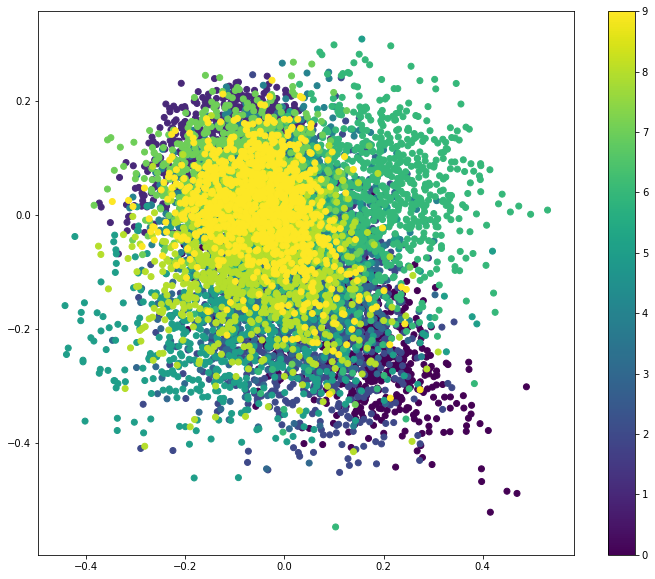

In [89]:
def plot_results(models,
                 data,
                 batch_size=100,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector
    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    print(z_mean)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
#     plt.xlabel("z[0]")
#     plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    
plot_results(models,
                 data,
                 batch_size=batch_size,
                 model_name="vae_mlp")

[[-0.037474   -0.04641288 -0.14980395 ... -0.01511603  0.0716449
  -0.08762412]
 [ 0.18308537 -0.15992731 -0.24455671 ...  0.02319774  0.06551719
  -0.08937447]
 [ 0.00071421 -0.16823818 -0.19852088 ... -0.05386624  0.09684668
  -0.06892179]
 ...
 [-0.26286155 -0.02181674 -0.06588515 ...  0.02279084  0.08969592
  -0.06488793]
 [-0.04859496  0.04163567 -0.00324217 ...  0.2430175   0.09782308
   0.04282188]
 [-0.05263731 -0.0167419  -0.02563624 ...  0.08706954  0.07859124
  -0.07928634]]


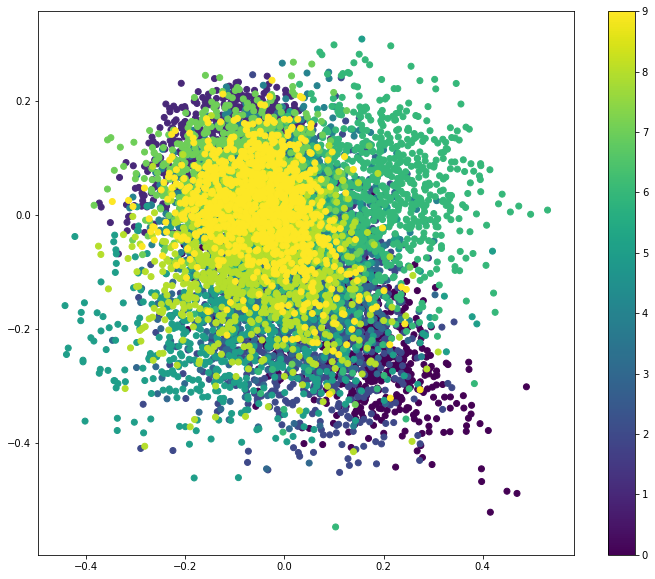

In [90]:
plot_results(models,
                 data,
                 batch_size=batch_size,
                 model_name="vae_mlp")

In [91]:
def plot_autoencoder_outputs(encoder,k, n, j, dims):
    #decoded_imgs = enconder.predict(x_test)
    #x_test_encoded = vae.predict(x_test, batch_size = batch_size)
    # number of example digits to show
    #n = 5
    plt.figure(figsize=(20, 5))
    for i in range(k, n):
        # plot original image
        ax = plt.subplot(2, n-k, i + 1-k)
        plt.imshow(x_test[j].reshape(*dims))
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Original Images')

        # plot reconstruction 
        ax = plt.subplot(2, n-k, i + 1 - k +n-k)
        plt.imshow(x_test_encoded[j].reshape(*dims))
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Reconstructed Images')
        j=j+1
    plt.show()

In [92]:
x_test_encoded = vae.predict(x_test, batch_size = 80)

In [93]:
print(x_test_encoded[10])

[[[0.         0.        ]
  [0.         0.        ]
  [0.         0.        ]
  ...
  [0.         0.        ]
  [0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]
  [0.         0.        ]
  ...
  [0.         0.        ]
  [0.         0.        ]
  [0.         0.        ]]

 [[0.         0.02265448]
  [0.         0.02172503]
  [0.         0.02461294]
  ...
  [0.         0.04331054]
  [0.         0.02070368]
  [0.         0.02392993]]

 ...

 [[0.         0.03299699]
  [0.         0.02299275]
  [0.         0.01300925]
  ...
  [0.         0.00925037]
  [0.         0.00934682]
  [0.         0.01329393]]

 [[0.         0.01717452]
  [0.         0.02076389]
  [0.         0.01169394]
  ...
  [0.         0.01069357]
  [0.         0.0214502 ]
  [0.         0.01893026]]

 [[0.         0.02611954]
  [0.         0.01279793]
  [0.         0.01264283]
  ...
  [0.         0.01654546]
  [0.         0.01854201]
  [0.         0.0201051 ]]]


In [94]:
x_test_encoded

array([[[[0.        , 0.        ],
         [0.        , 0.        ],
         [0.        , 0.        ],
         ...,
         [0.        , 0.        ],
         [0.        , 0.        ],
         [0.        , 0.        ]],

        [[0.        , 0.        ],
         [0.        , 0.        ],
         [0.        , 0.        ],
         ...,
         [0.        , 0.        ],
         [0.        , 0.        ],
         [0.        , 0.        ]],

        [[0.        , 0.02271157],
         [0.        , 0.02168179],
         [0.        , 0.02365435],
         ...,
         [0.        , 0.04234369],
         [0.        , 0.02378583],
         [0.        , 0.02375049]],

        ...,

        [[0.        , 0.03353009],
         [0.        , 0.02279526],
         [0.        , 0.01124515],
         ...,
         [0.        , 0.00742063],
         [0.        , 0.00777824],
         [0.        , 0.01171925]],

        [[0.        , 0.01683014],
         [0.        , 0.0191572 ],
         [0.

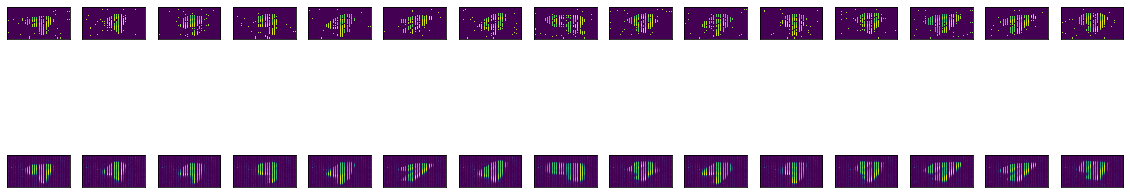

In [95]:
plot_autoencoder_outputs(x_test_encoded, 0, 15, 9500, (36, 72))

In [96]:
vae_test.set_weights(vae.get_weights())

from random import shuffle

#shuffle(x_test)

score = vae_test.evaluate(x_test, x_test, verbose=1, batch_size=80)
#score = vae.evaluate(x_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 2s 199us/step
Test loss: 0.1131817684173584
Test accuracy: 0.8912755408287049


In [97]:
#np.delete(x_test_encoded, [35, 0], axis = 0).shape
# np.delete(x_test_encoded, 0, axis = 0)
# np.delete(x_test_encoded, 35, axis = 1)
# np.delete(x_test_encoded, 0, axis = 1)
x_test_encoded.shape

(10000, 36, 36, 2)

In [98]:
x_test_encoded_2 = np.zeros((10000, 34, 36, 2))
x_test_encoded_3 = np.zeros((10000, 34, 34, 2))
for i in range (0, x_test_encoded.shape[0]):
    print(i)
    x_test_encoded_2[i] = np.delete(x_test_encoded[i], [35, 0], axis = 0)
for i in range (0, x_test_encoded_2.shape[0]):
    print(i)
    x_test_encoded_3[i] = np.delete(x_test_encoded_2[i], [35, 0], axis = 1)


# As a sanity check, we print out the size of the training and test data.
print('Original data shape: ', x_test_encoded.shape)
print('Modified labels shape: ', x_test_encoded_3.shape)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
2371
2372
2373
2374
2375
2376
2377
2378
2379
2380
2381
2382
2383
2384
2385
2386
2387
2388
2389
2390
2391
2392
2393
2394
2395
2396
2397
2398
2399
2400
2401
2402
2403
2404
2405
2406
2407
2408
2409
2410
2411
2412
2413
2414
2415
2416
2417
2418
2419
2420
2421
2422
2423
2424
2425
2426
2427
2428
2429
2430
2431
2432
2433
2434
2435
2436
2437
2438
2439
2440
2441
2442
2443
2444
2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2455
2456
2457
2458
2459
2460
2461
2462
2463
2464
2465
2466
2467
2468
2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2479
2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499
2500
2501
2502


3966
3967
3968
3969
3970
3971
3972
3973
3974
3975
3976
3977
3978
3979
3980
3981
3982
3983
3984
3985
3986
3987
3988
3989
3990
3991
3992
3993
3994
3995
3996
3997
3998
3999
4000
4001
4002
4003
4004
4005
4006
4007
4008
4009
4010
4011
4012
4013
4014
4015
4016
4017
4018
4019
4020
4021
4022
4023
4024
4025
4026
4027
4028
4029
4030
4031
4032
4033
4034
4035
4036
4037
4038
4039
4040
4041
4042
4043
4044
4045
4046
4047
4048
4049
4050
4051
4052
4053
4054
4055
4056
4057
4058
4059
4060
4061
4062
4063
4064
4065
4066
4067
4068
4069
4070
4071
4072
4073
4074
4075
4076
4077
4078
4079
4080
4081
4082
4083
4084
4085
4086
4087
4088
4089
4090
4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165


5942
5943
5944
5945
5946
5947
5948
5949
5950
5951
5952
5953
5954
5955
5956
5957
5958
5959
5960
5961
5962
5963
5964
5965
5966
5967
5968
5969
5970
5971
5972
5973
5974
5975
5976
5977
5978
5979
5980
5981
5982
5983
5984
5985
5986
5987
5988
5989
5990
5991
5992
5993
5994
5995
5996
5997
5998
5999
6000
6001
6002
6003
6004
6005
6006
6007
6008
6009
6010
6011
6012
6013
6014
6015
6016
6017
6018
6019
6020
6021
6022
6023
6024
6025
6026
6027
6028
6029
6030
6031
6032
6033
6034
6035
6036
6037
6038
6039
6040
6041
6042
6043
6044
6045
6046
6047
6048
6049
6050
6051
6052
6053
6054
6055
6056
6057
6058
6059
6060
6061
6062
6063
6064
6065
6066
6067
6068
6069
6070
6071
6072
6073
6074
6075
6076
6077
6078
6079
6080
6081
6082
6083
6084
6085
6086
6087
6088
6089
6090
6091
6092
6093
6094
6095
6096
6097
6098
6099
6100
6101
6102
6103
6104
6105
6106
6107
6108
6109
6110
6111
6112
6113
6114
6115
6116
6117
6118
6119
6120
6121
6122
6123
6124
6125
6126
6127
6128
6129
6130
6131
6132
6133
6134
6135
6136
6137
6138
6139
6140
6141


8066
8067
8068
8069
8070
8071
8072
8073
8074
8075
8076
8077
8078
8079
8080
8081
8082
8083
8084
8085
8086
8087
8088
8089
8090
8091
8092
8093
8094
8095
8096
8097
8098
8099
8100
8101
8102
8103
8104
8105
8106
8107
8108
8109
8110
8111
8112
8113
8114
8115
8116
8117
8118
8119
8120
8121
8122
8123
8124
8125
8126
8127
8128
8129
8130
8131
8132
8133
8134
8135
8136
8137
8138
8139
8140
8141
8142
8143
8144
8145
8146
8147
8148
8149
8150
8151
8152
8153
8154
8155
8156
8157
8158
8159
8160
8161
8162
8163
8164
8165
8166
8167
8168
8169
8170
8171
8172
8173
8174
8175
8176
8177
8178
8179
8180
8181
8182
8183
8184
8185
8186
8187
8188
8189
8190
8191
8192
8193
8194
8195
8196
8197
8198
8199
8200
8201
8202
8203
8204
8205
8206
8207
8208
8209
8210
8211
8212
8213
8214
8215
8216
8217
8218
8219
8220
8221
8222
8223
8224
8225
8226
8227
8228
8229
8230
8231
8232
8233
8234
8235
8236
8237
8238
8239
8240
8241
8242
8243
8244
8245
8246
8247
8248
8249
8250
8251
8252
8253
8254
8255
8256
8257
8258
8259
8260
8261
8262
8263
8264
8265


467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716


2848
2849
2850
2851
2852
2853
2854
2855
2856
2857
2858
2859
2860
2861
2862
2863
2864
2865
2866
2867
2868
2869
2870
2871
2872
2873
2874
2875
2876
2877
2878
2879
2880
2881
2882
2883
2884
2885
2886
2887
2888
2889
2890
2891
2892
2893
2894
2895
2896
2897
2898
2899
2900
2901
2902
2903
2904
2905
2906
2907
2908
2909
2910
2911
2912
2913
2914
2915
2916
2917
2918
2919
2920
2921
2922
2923
2924
2925
2926
2927
2928
2929
2930
2931
2932
2933
2934
2935
2936
2937
2938
2939
2940
2941
2942
2943
2944
2945
2946
2947
2948
2949
2950
2951
2952
2953
2954
2955
2956
2957
2958
2959
2960
2961
2962
2963
2964
2965
2966
2967
2968
2969
2970
2971
2972
2973
2974
2975
2976
2977
2978
2979
2980
2981
2982
2983
2984
2985
2986
2987
2988
2989
2990
2991
2992
2993
2994
2995
2996
2997
2998
2999
3000
3001
3002
3003
3004
3005
3006
3007
3008
3009
3010
3011
3012
3013
3014
3015
3016
3017
3018
3019
3020
3021
3022
3023
3024
3025
3026
3027
3028
3029
3030
3031
3032
3033
3034
3035
3036
3037
3038
3039
3040
3041
3042
3043
3044
3045
3046
3047


5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407
5408
5409
5410
5411
5412
5413
5414
5415
5416
5417
5418
5419
5420
5421
5422
5423
5424
5425
5426
5427
5428
5429
5430
5431
5432
5433
5434
5435
5436
5437
5438
5439
5440
5441
5442
5443
5444
5445
5446
5447
5448
5449
5450
5451
5452


7639
7640
7641
7642
7643
7644
7645
7646
7647
7648
7649
7650
7651
7652
7653
7654
7655
7656
7657
7658
7659
7660
7661
7662
7663
7664
7665
7666
7667
7668
7669
7670
7671
7672
7673
7674
7675
7676
7677
7678
7679
7680
7681
7682
7683
7684
7685
7686
7687
7688
7689
7690
7691
7692
7693
7694
7695
7696
7697
7698
7699
7700
7701
7702
7703
7704
7705
7706
7707
7708
7709
7710
7711
7712
7713
7714
7715
7716
7717
7718
7719
7720
7721
7722
7723
7724
7725
7726
7727
7728
7729
7730
7731
7732
7733
7734
7735
7736
7737
7738
7739
7740
7741
7742
7743
7744
7745
7746
7747
7748
7749
7750
7751
7752
7753
7754
7755
7756
7757
7758
7759
7760
7761
7762
7763
7764
7765
7766
7767
7768
7769
7770
7771
7772
7773
7774
7775
7776
7777
7778
7779
7780
7781
7782
7783
7784
7785
7786
7787
7788
7789
7790
7791
7792
7793
7794
7795
7796
7797
7798
7799
7800
7801
7802
7803
7804
7805
7806
7807
7808
7809
7810
7811
7812
7813
7814
7815
7816
7817
7818
7819
7820
7821
7822
7823
7824
7825
7826
7827
7828
7829
7830
7831
7832
7833
7834
7835
7836
7837
7838


In [99]:
np.save("x_test_cvae_1",x_test_encoded_3)
np.save("y_test_cvae", y_test)

In [100]:

np.save("x_test",x_test_1)


In [101]:
x_test_encoded_3.shape

(10000, 34, 34, 2)

In [102]:
# Saving models
encoder.save('cvae_encoder.h5')
encoder.save_weights('encoder_weights.h5')

decoder.save('cvae_decoder.h5')
decoder.save_weights('decoder_weights.h5')


vae.save('cvae.h5')

In [103]:
#class_encoder = load_model('cvae_encoder.h5')
class_encoder = Model(inputs, [z_mean, z_log_var, z], name='class_encoder')


In [104]:
#class_encoder = load_model('cvae_encoder.h5')
class_encoder.load_weights('encoder_weights.h5')

In [105]:
class_encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 36, 36, 2)    0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 36, 36, 16)   304         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 36, 36, 32)   2080        conv2d_9[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 18, 18, 32)   0           conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_11 

In [106]:
x_train_encoded = encoder.predict(x_train, batch_size = 80)
#x_train_encoded.shape()

In [107]:
#use [2] as in the mode;
x_train_encoded[2]

array([[ 0.12585573, -0.15592518, -0.03648941, ...,  0.09854962,
        -0.05417457, -0.10115538],
       [ 0.11613348, -0.24378139,  0.01616512, ...,  0.18614008,
         0.0159028 , -0.02426568],
       [ 0.04058922, -0.05705947, -0.02145027, ...,  0.03645498,
         0.03186345, -0.00046865],
       ...,
       [-0.12693034,  0.05850767, -0.09749924, ...,  0.0098604 ,
        -0.08248924, -0.06086332],
       [-0.05393965,  0.09466013, -0.0380688 , ...,  0.09166994,
        -0.07637589, -0.07032973],
       [-0.02850191,  0.1434507 , -0.00219116, ...,  0.11864475,
        -0.05049095, -0.03576504]], dtype=float32)

In [108]:
encoder.output_shape

[(None, 10), (None, 10), (None, 10)]

In [40]:
from sklearn import svm


In [148]:
clf = svm.SVC(gamma='auto', C=5000 )


In [149]:
clf.fit(x_train_encoded[2], y_train)

SVC(C=5000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [116]:
x_test_encoded_1 = encoder.predict(x_test, batch_size = 80)


In [150]:
clf.score(x_test_encoded_1[2], y_test)

0.9004

In [113]:
x_train_encoded[2][0][0]

0.12585573